# Potential flow - two bodies

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using LinearAlgebra

In [4]:
"""
integrate(f::Function,xmin::Real,xmax::Real,N::Int,name::String) -> Real
Integrate the function `f` between the limits `xmin` to `xmax` with `N` intervals using either the `"trapezoidal"` or `"simpson"` rule specified in `name`. The solution is returned as a Real value.
"""
function surface_integrate(body::Body{N},integrand::Array{Float64,1}) where {N}
    func = Array{Float64,1}(undef, N+1)
    func[1:end-1] .= integrand
    func[end] = integrand[1]
    s = sum(Bodies.dlength(body).*(func[1:end-1] + func[2:end]))
    return s
end

surface_integrate

In [5]:
𝐞₁ = [1;0];
𝐞₂ = [0;1];

In [6]:
nx = 500; ny = 252;
Lx = 4.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny)); w .= 0; # No vorticity
ψ = Nodes(Dual,w);

In [7]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 500, ny = 252) grid with spacing 1.0

In [8]:
n = 400

R = 0.5
body_1 = Ellipse(R,R,n)
body_2 = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body_1))

# Move the bodies
xc_1 = 1.0; yc_1 = 1.0
xc_2 = 3.0; yc_2 = 1.0
T_1 = RigidTransform((xc_1,yc_1),0.0)
T_1(body_1)
T_2 = RigidTransform((xc_2,yc_2),0.0)
T_2(body_2)

# Area of the circles
𝒱 = π*R^2

0.7853981633974483

In [9]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 0.9778106606445316


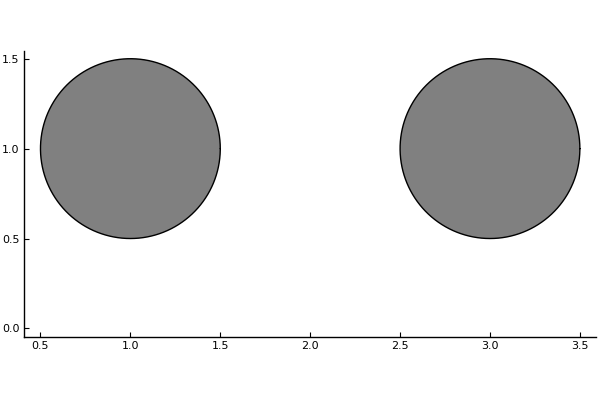

In [10]:
plot(body_1,fillcolor=:grey,fillrange=0,fillalpha=1.0,linecolor=:black)
plot!(body_2,fillcolor=:grey,fillrange=0,fillalpha=1.0,linecolor=:black)

In [11]:
X = VectorData([body_1.x;body_2.x],[body_1.y;body_2.y])
f = ScalarData(X);
ψb = ScalarData(X);

oB = zeros(2*n,2)
oB[1:n,1] .= 1;
oB[n+1:2*n,2] .= 1;

# The desired circulation about the cylinders
Γ_1 = 0;
Γ_2 = 0;
Γ = [Γ_1;Γ_2]

# Velocity of the cylinders
U_1 = 0;
V_1 = 1;
U_2 = 0;
V_2 = 0;

# Streamfunction constraint on the cylinders
ψb[1:n] .= U_1*(body_1.y .- body_1.cent[2]) - V_1*(body_1.x .- body_1.cent[1]);
ψb[n+1:end] .= U_2*(body_2.y .- body_2.cent[2]) - V_2*(body_2.x .- body_2.cent[1]);

In [12]:
L⁻¹(w::T) where {T} = L\w;
E = Regularize(X,dx;issymmetric=true);
Hmat,Emat = RegularizationMatrix(E,f,w);
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true);
S = Matrix(PS.S);
S₀ = transpose(oB)*(S\oB);

In [21]:
T = S - oB*(S₀\transpose(oB));
f .= S\(T*(S\(Emat*(L\w).+ψb)) .+ oB*(S₀\Γ));
ψ₀ = -S₀\(Γ - transpose(oB)*(S\(Emat*(L\w) .+ ψb)));
ψ .= -(L\(Hmat*f))-(L\(w));# .+ ψ₀;  

In [22]:
ψ₀

2-element Array{Float64,1}:
 -0.008558139120468046
  0.1269201729580983  

In [15]:
f

800 points of scalar-valued data
800-element Array{Float64,1}:
 -0.016008670638443613 
 -0.0160048708956296   
 -0.01600011957911432  
 -0.015974648456975275 
 -0.015961995540850985 
 -0.015880491368807533 
 -0.015859235085170457 
 -0.01575092074340453  
 -0.016087751695719483 
 -0.015517479827757048 
 -0.016508938314969853 
 -0.014902269517755681 
 -0.01700912515324909  
  ⋮                    
 -0.0006950889356303297
 -0.0006060370635990967
 -0.0006707693379008126
 -0.0006282324427148643
 -0.0006505213906631796
 -0.000635395847570013 
 -0.000638957682048871 
 -0.0006388558199774505
 -0.000641477605832939 
 -0.0006414122527433007
 -0.0006420518064117473
 -0.0006420017051146153

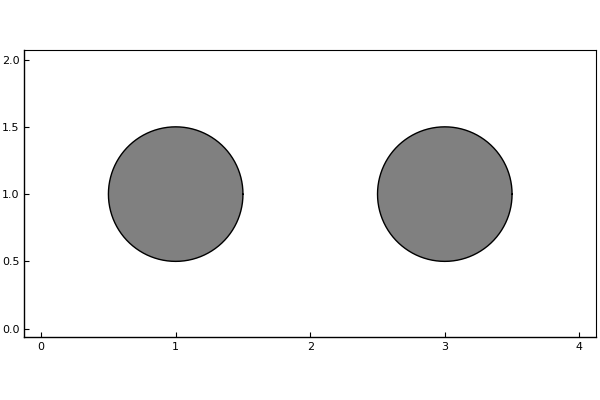

In [16]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=200))
plot!(body_1,fillcolor=:grey,fillrange=0,fillalpha=1.0,linecolor=:black)
plot!(body_2,fillcolor=:grey,fillrange=0,fillalpha=1.0,linecolor=:black)

In [17]:
println("circulation about circle 1 = ",sum(f[1:n]))
println("circulation about circle 2 = ",sum(f[n+1:2*n]))

circulation about circle 1 = 8.673617379884035e-16
circulation about circle 2 = -4.4885969940899884e-17


In [18]:
integrand_1_x = (f[1:n]./Bodies.dlength(body_1)).*(body_1.y);
integrand_1_y = -(f[1:n]./Bodies.dlength(body_1)).*(body_1.x);
integrand_2_x = (f[n+1:end]./Bodies.dlength(body_2)).*(body_2.y);
integrand_2_y = -(f[n+1:end]./Bodies.dlength(body_2)).*(body_2.x);
# writedlm("integrand_x_two_bodies.csv",integrand_2_x, ',')

In [19]:
# P¹ = -𝒱*𝐞₁ + 0.5*[surface_integrate(body_1,integrand_1_x);surface_integrate(body_1,integrand_1_y)]
# P² = -𝒱*𝐞₂ + 0.5*[surface_integrate(body_1,integrand_1_x);surface_integrate(body_1,integrand_1_y)]
# P¹ = -𝒱*𝐞₁ + 0.5*[surface_integrate(body_2,integrand_2_x);surface_integrate(body_2,integrand_2_y)]
P² = -𝒱*𝐞₂ + 0.5*[surface_integrate(body_2,integrand_2_x);surface_integrate(body_2,integrand_2_y)]

2-element Array{Float64,1}:
 -8.131516293641283e-17
 -0.6846454968209301   

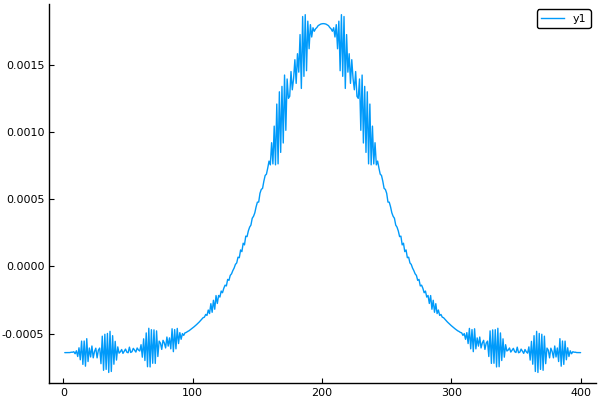

In [53]:
plot(f[n+1:end])

In [56]:
0.5*[surface_integrate(body_2,integrand_2_x);surface_integrate(body_2,integrand_2_y)]

2-element Array{Float64,1}:
 -8.131516293641283e-17
  0.10075266657651812  